# **1 - Clustering: Balearic Assemblages & Spatial**

##### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy
from pathlib import Path
from sklearn.cluster import DBSCAN, SpectralBiclustering

# Read data

#### *Project main path*

In [2]:
pth = Path(r'..\data')
pth

WindowsPath('../data')

### Read Balearic survey data
This csv file contains the identifier of each survey point and its easting and northing. It also contains the presence ceramic types at each point. This file has been generated after selecting those survey points with diagnostic wares for the Balearic period.

In [3]:
fn =pth / 'artifacts' / 'balearic_presence.txt'
data= pd.read_csv(fn, index_col= ['SurveyPointId', 'Easting', 'Northing'])
data.shape

(832, 4)

In [4]:
data.head(10)

,,,Amphora,Coarseware,Commonware,Fineware
SurveyPointId,Easting,Northing,,,,
02001d-77-012,531989.73,4385614.15,1.0,0.0,0.0,0.0
02001d-80-008,531872.15,4385569.72,1.0,0.0,0.0,0.0
02001d-82-024,532116.88,4385546.76,1.0,0.0,0.0,0.0
021540-83-107,532127.62,4385358.91,0.0,1.0,0.0,0.0
021540-84-208,532164.35,4385338.75,1.0,0.0,0.0,0.0
021540-85-408,532151.02,4385346.02,1.0,0.0,0.0,0.0
03039b-14-311,532676.30,4385941.44,0.0,1.0,0.0,0.0
03039b-14-312,532663.24,4385944.05,0.0,1.0,1.0,0.0
03039b-44-318,532729.52,4385777.52,1.0,0.0,0.0,0.0


# Clustering

We shall group points using two different clustering methods:
- Spectral Biclustering using *assemblage* coefficient
- DBSCAN using euclidean distance


## Spectral biclustering method

For this method we want to use our own dissimilarity coefficient. In order to do this, we shall first create a function that takes four parameters (a, b, c, d) and calculates the dissimilarity coefficient for two rows or survey points. The parameters correspond to the following table,

|               |*Presence2*| *Absence2*|
|:-------------:|:---------:|:---------:|
|**_Presence1_**|     a     |     b     |
|**_Absence1_** |     c     |     d     |

Here *a* would correspond to the number of categories (= ceramic types) that are present in two rows or survey points we are comparing, *b* would correspond to the number of types that are in row1 and not in row2 and so on. Once we have these counts we plug it in the following formula: 

$$ diss = \frac{b+c}{5a + b + c + \frac{d}{5}} $$

to calculate a dissimilarity coefficient between the two rows (survey points)

#### Define *Assemblage* dissimilarity coefficient

In [5]:
# Dissimilarity metric
def mll(a,b,c,d, coefad=5, coefbc=1):
    return (coefbc*b + coefbc*c) / (coefad*a + coefbc*b + coefbc*c + d/coefad)

In [6]:
# generate dissimilarity matrix
from leiap_survey.cluster import create_binary_metric_matrix
D_mll = create_binary_metric_matrix(data.values, mll)  

In [7]:
D_mll.shape

(832, 832)

#### Explore number of cluster using a Silhouette Plot

Use `random_state=13` to reproduce the results from the article

In [8]:
from leiap_survey.cluster import plot_silhouette

For n_clusters = 2 The average silhouette_score is : 0.7733263399522324
For n_clusters = 3 The average silhouette_score is : 0.6566966586355097
For n_clusters = 4 The average silhouette_score is : 0.870672369343864
For n_clusters = 5 The average silhouette_score is : 0.8977618529492422
For n_clusters = 6 The average silhouette_score is : 0.9054196870495771
For n_clusters = 7 The average silhouette_score is : 0.9287176996792378


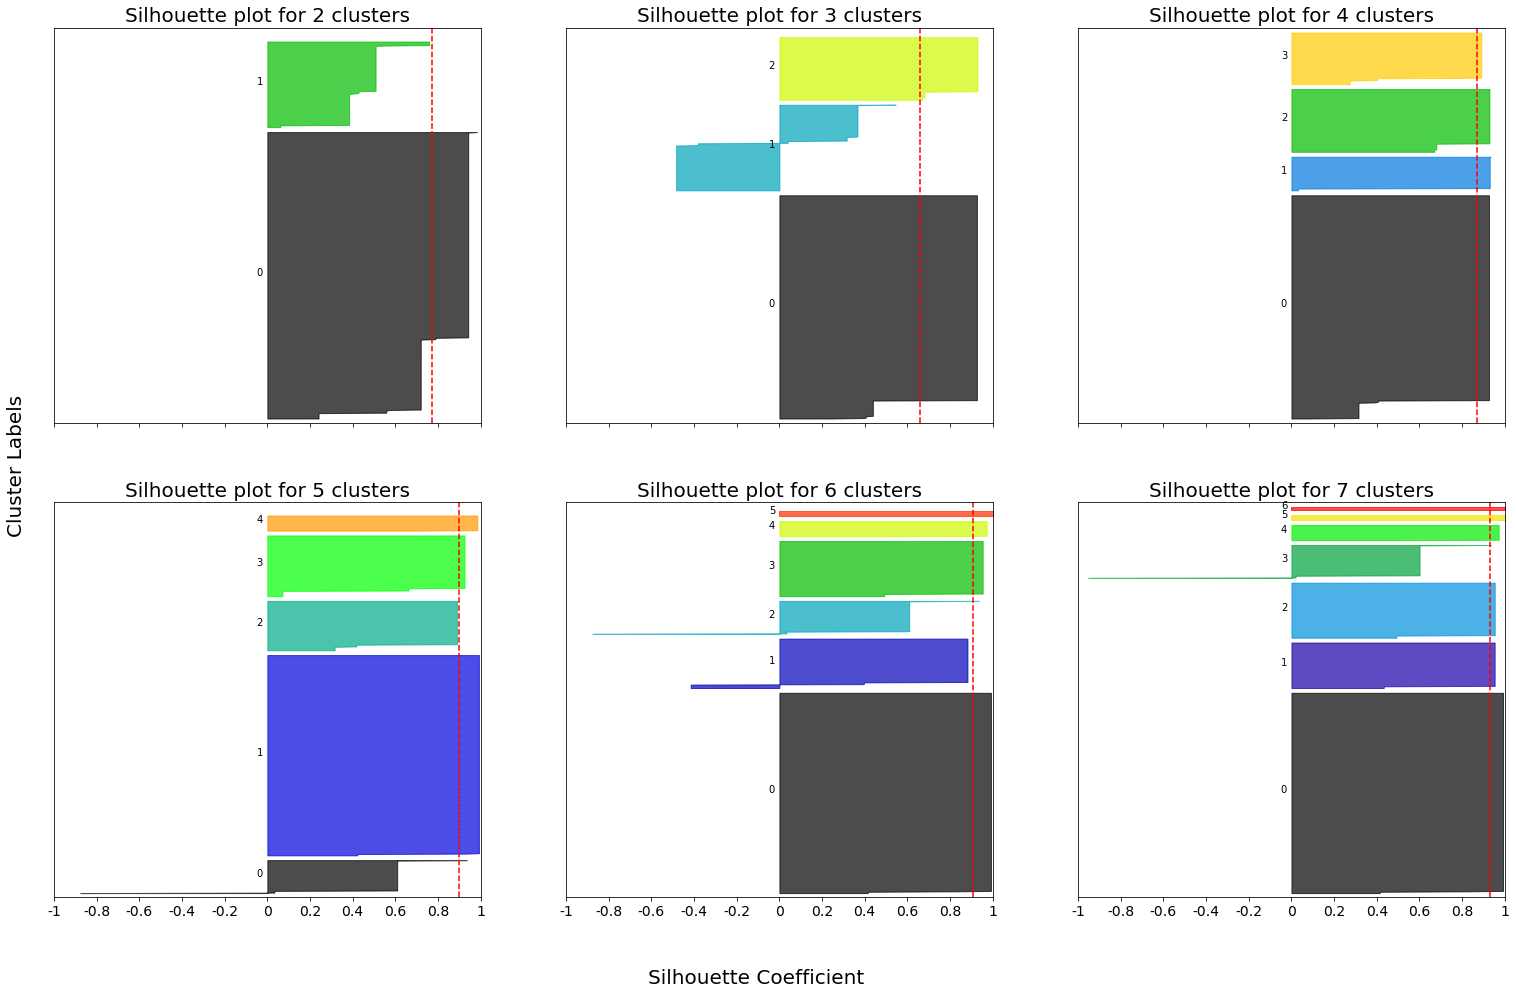

In [9]:
clst_kw = {'random_state': 13, 'n_init':100, 'svd_method':'arpack'}
plot_silhouette(D_mll, [2,3,4,5,6,7], SpectralBiclustering, clst_kw,
                func_lbl= lambda Clusterer: Clusterer.row_labels_,
                save='silhouette_spectral', size=(26,16), colrow=(2,3))


#### Run Spectral Biclustering using four clusters

In [10]:
Biclst = SpectralBiclustering(n_clusters=4, random_state= 13, n_init=100, svd_method='arpack')
Biclst.fit(D_mll)

SpectralBiclustering(n_clusters=4, n_init=100, random_state=13,
                     svd_method='arpack')

In [11]:
from leiap_survey.cluster import sort_cluster_labels
data['Biclst'] = sort_cluster_labels(Biclst.row_labels_)

## Spatial clustering using DBSCAN

#### Extract location 

In [12]:
loc = data.reset_index()[['Northing', 'Easting']].to_numpy()

### Determine most optimal distance for a cluster with a minimum of 4 survey points

#### Find nearest neighbors

In [13]:
from sklearn.neighbors import NearestNeighbors

# find nearest 10 neighbors
nmax = 10
neighs = NearestNeighbors(n_neighbors = nmax)
neighs_fit = neighs.fit(loc)
distances, indices = neighs_fit.kneighbors(loc)

#### Find cutoff distance
We are going to consider that a minimum cluster should be made by at least 4 survey points. In order to determine the distance given this minimum number of survey points, we plot all the distances to the fourth nearest neighbor and select where there is a big change.

In [14]:
from kneed import KneeLocator
from  scipy.signal import savgol_filter
n = 4-1
y  = np.sort(distances, axis=0)[:,n]
x = np.arange(y.size)
kneedle = KneeLocator(x,savgol_filter(y, 21, 3), curve='convex', direction='increasing')
print(f'Knee occurs at x= {kneedle.knee} and y= {y[kneedle.knee]:.2f}')

Knee occurs at x= 719 and y= 61.07


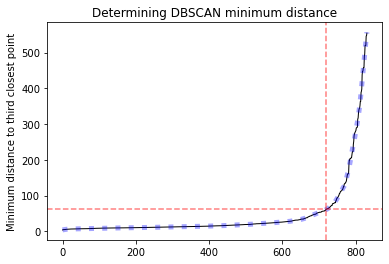

In [15]:
fig, ax = plt.subplots()
ax.plot(x, y, c='k', linewidth=1)
ax.plot(x, savgol_filter(y, 31, 3), c='blue', linestyle=':', linewidth=5, alpha=0.35)
ax.axhline(y=y[kneedle.knee], c='red', alpha=0.5, linestyle='--')
ax.axvline(x=kneedle.knee, c='red', alpha=0.5, linestyle='--')
ax.set_ylabel('Minimum distance to third closest point')
ax.set_title('Determining DBSCAN minimum distance');

### Run dbscan

In [16]:
db_scan = DBSCAN(eps= 61.07, min_samples=4) 
db_scan.fit(loc)

DBSCAN(eps=61.07, min_samples=4)

In [17]:
data['dbscan'] = db_scan.labels_

##### Save Clustered Survey Points

In [18]:
fn = pth / 'output' / 'clusters.txt'
#data.to_csv(fn)